In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import early_stopping,log_evaluation, Dataset, LGBMClassifier
import lightgbm as lgb
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import accuracy_score,make_scorer 
from sklearn import set_config
import warnings
import optuna
from sklearn.preprocessing import PolynomialFeatures,OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from pprint import pprint
from time import time
from scipy.stats import kurtosis, skew, gmean, mode,trim_mean, mstats
from scipy.stats.mstats import winsorize
# Skopt functions
from skopt import BayesSearchCV
from skopt import gp_minimize # Bayesian optimization using Gaussian Processes
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args # decorator to convert a list of parameters to named arguments
from skopt.callbacks import DeadlineStopper # Stop the optimization before running out of a fixed budget of time.
from skopt.callbacks import VerboseCallback # Callback to control the verbosity
from skopt.callbacks import DeltaXStopper # Stop the optimization If the last two positions at which the objective has been evaluated are less than delta

warnings.filterwarnings('ignore')

sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')

pd.set_option('display.max_rows', 100)
set_config(transform_output = 'pandas')
pd.options.mode.chained_assignment = None

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e6/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e6/test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 38 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   id                                              76518 non-null  int64  
 1   Marital status                                  76518 non-null  int64  
 2   Application mode                                76518 non-null  int64  
 3   Application order                               76518 non-null  int64  
 4   Course                                          76518 non-null  int64  
 5   Daytime/evening attendance                      76518 non-null  int64  
 6   Previous qualification                          76518 non-null  int64  
 7   Previous qualification (grade)                  76518 non-null  float64
 8   Nacionality                                     76518 non-null  int64  
 9   Mother's qualification                 

<Axes: xlabel='Target'>

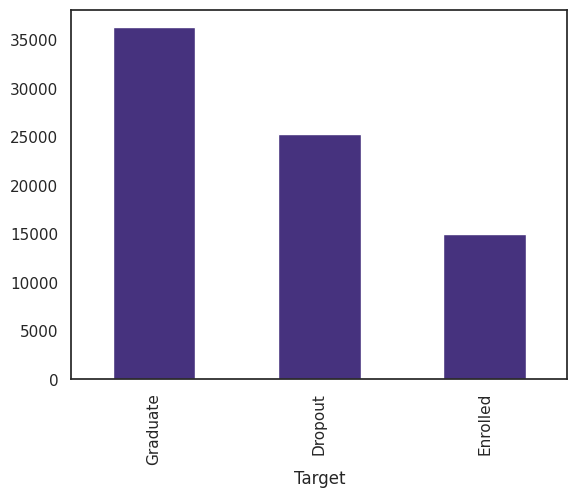

In [4]:
train.Target.value_counts().plot(kind='bar')

In [5]:
# The replacing of values is taken from following notebook
# https://www.kaggle.com/code/gauravduttakiit/pss4e6-flaml-roc-auc-ovo/notebook

class Model:
    def __init__(self, train, test):
        self.train = train
        self.test = test
        self.model_dict = dict()
        self.test_predict_list = list()
     
    def preprocess(self):
        self.train.Target = self.train.Target.map({"Graduate":0,
                                                  "Dropout":1,
                                                  "Enrolled":2})
        self.train['Application mode']=self.train['Application mode'].replace({12:np.NaN,
                                                           4:np.NaN,
                                                            35:np.NaN,
                                                            9:np.NaN,
                                                            3:np.NaN}
                                                           )
        self.test['Application mode']=self.test['Application mode'].replace({14:np.NaN,
                                                           35:np.NaN,
                                                            19:np.NaN,
                                                            3:np.NaN}
                                                           )
        self.train['Course']=self.train['Course'].replace({979:np.NaN,
                                         39:np.NaN })
        self.test['Course']=self.test['Course'].replace({7500:np.NaN,
                                         9257:np.NaN,
                                        2105:np.NaN,
                                         4147:np.NaN,})
        self.train['Previous qualification']=self.train['Previous qualification'].replace({37:np.NaN,
                                         36:np.NaN, 
                                        17:np.NaN,
                                        11:np.NaN})
        self.test['Previous qualification']=self.test['Previous qualification'].replace({17:np.NaN,
                                                                       11:np.NaN,
                                                                       16:np.NaN})
    
    def fit(self,params,name):
        target_col = ['Target']
        drop_col = ['id']
        self.preprocess()
        
        train_cols = [col for col in self.train.columns.to_list() if col not in target_col + drop_col]
        scores = list()
        
        
        for i in range(1):
            mskf = RepeatedKFold(n_splits=10, n_repeats=1,random_state=22)
            oof_valid_preds = np.zeros(self.train[train_cols].shape[0])
                
            for fold, (train_idx, valid_idx) in enumerate(mskf.split(self.train[train_cols], self.train[target_col])):
                X_train, y_train = self.train[train_cols].iloc[train_idx], self.train[target_col].iloc[train_idx]
                X_valid, y_valid = self.train[train_cols].iloc[valid_idx], self.train[target_col].iloc[valid_idx]
                
                if name == 'lgbm':
                    algo = LGBMClassifier(random_state=i+fold,**params)
                    algo.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
                elif name== 'catboost':
                    algo = CatBoostlassifier(random_state=i+fold,**params)
                else:
                    algo = XGBClassifier(random_state=i+fold, missing=float('inf'),**params)
                    algo.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],verbose=False)
                    
                valid_preds = algo.predict(X_valid)
                oof_valid_preds[valid_idx] = valid_preds
                test_predict = algo.predict(self.test[train_cols])
                self.test_predict_list.append(test_predict)
                score = accuracy_score(y_valid, valid_preds)
                print(f"\nFold: {fold+1}\n===>Accuracy score: {score}")
                self.model_dict[f'fold_{fold}'] = algo
                    
            oof_score = accuracy_score(self.train[target_col], oof_valid_preds)
            print(f"The OOF accuracy score for iteration {i+1} is {oof_score}")
            scores.append(oof_score)
        predictions_3d = np.array(self.test_predict_list)

        # Perform majority voting to find the final prediction for each entry
        final_predictions = []
        for entry_predictions in predictions_3d.T:  # Iterate over each entry's predictions
            unique, counts = np.unique(entry_predictions, return_counts=True)
            final_predictions.append(unique[np.argmax(counts)])

        return final_predictions
    
    def report_perf(self,optimizer, X, y, title, callbacks=None):
        """
        A wrapper for measuring time and performances of different optmizers

        optimizer = a sklearn or a skopt optimizer
        X = the training set 
        y = our target
        title = a string label for the experiment
        """
        start = time()
        if callbacks:
            optimizer.fit(X, y, callback=callbacks)
        else:
            optimizer.fit(X, y)
        best_score = optimizer.best_score_
        best_score_std = optimizer.cv_results_['std_test_score'][optimizer.best_index_]
        best_params = optimizer.best_params_
        print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.6f "
               +u"\u00B1"+" %.6f") % (time() - start, 
                                      len(optimizer.cv_results_['params']),
                                      best_score,
                                      best_score_std))    
        print('Best parameters:')
        pprint(best_params)
        print()
        return best_params
    
    
    def find_params(self):
        self.preprocess()
        avg_acc = make_scorer(accuracy_score, greater_is_better=True, needs_proba=False)
        search_spaces = {
            'num_leaves': Integer(2, 210, prior='uniform'),
            'learning_rate': Real(0.001, 0.1, prior='log-uniform'),
            'n_estimators': Integer(50, 1000, prior='uniform'),
            'subsample_for_bin': Integer(10000, 500000, prior='uniform'),
            'min_child_samples': Integer(1, 100, prior='uniform'),
            'reg_alpha': Real(1e-10, 1e-5, prior='log-uniform'),
            'reg_lambda': Real(1e-10, 1e-5, prior='log-uniform'),
            'colsample_bytree': Real(0.1, 0.9, prior='uniform'),
            'subsample': Real(0.5, 1.0, prior='uniform'),
            'max_depth': Integer(2, 20, prior='uniform')
        }
        skf = RepeatedKFold(n_splits=10, n_repeats=1,random_state=42)

        opt = BayesSearchCV(LGBMClassifier(verbosity=-1,device='gpu'),
                    search_spaces,
                    scoring=avg_acc,
                    cv=skf,
                    n_iter=10000,
                    n_jobs=1,  
                    return_train_score=False,
                    refit=True,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state=22)
        target_col = ['Target']
        drop_col = ['id']
        train_cols = [col for col in self.train.columns.to_list() if col not in target_col + drop_col]
        X = self.train[train_cols]
        y = self.train[target_col]
        best_params = self.report_perf(opt, X, y,'LightBoost', 
                          callbacks=[DeltaXStopper(0.001), 
                                     DeadlineStopper(60*60*11)])

In [6]:
lgbm_params = {
    'num_leaves': 10,
    'learning_rate': 0.1,
    'n_estimators': 804,
    'subsample_for_bin': 358627,
    'min_child_samples': 65,
    'reg_alpha': 1e-10,
    'reg_lambda': 7.997658533963912e-06,
    'colsample_bytree': 0.16449192917682687,
    'subsample': 0.8882838011514074,
    'max_depth': 14,
    'device':'gpu',
        'verbosity':-1,"objective": "multiclass",          
                    "metric": "multi_logloss",
}

In [7]:
model = Model(train,test)
lgbm_preds = model.fit(lgbm_params,'lgbm')

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.



Fold: 1
===>Accuracy score: 0.8391270256142185

Fold: 2
===>Accuracy score: 0.8311552535284893

Fold: 3
===>Accuracy score: 0.8316779926816519

Fold: 4
===>Accuracy score: 0.8357292211186618

Fold: 5
===>Accuracy score: 0.8314166231050706

Fold: 6
===>Accuracy score: 0.8365133298484057

Fold: 7
===>Accuracy score: 0.8240982749607946

Fold: 8
===>Accuracy score: 0.8315473078933612

Fold: 9
===>Accuracy score: 0.8291726571689975

Fold: 10
===>Accuracy score: 0.8371454711802379
The OOF accuracy score for iteration 1 is 0.8327583052353694


In [8]:
label_mapping = {
    0: "Graduate",
    1: "Dropout",
    2: "Enrolled"
}
predicted_labels = [label_mapping[value] for value in lgbm_preds]

In [9]:
submit = pd.read_csv('/kaggle/input/playground-series-s4e6/sample_submission.csv')
submit.Target = predicted_labels
submit.to_csv('submission.csv',index=False)
submit

,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Enrolled
4,76522,Enrolled
...,...,...
51007,127525,Dropout
51008,127526,Dropout
51009,127527,Dropout
51010,127528,Dropout
